Welcome to the AI Game Level Generator!

Available Game Types:
1. Board
2. Maze
3. Puzzle

Select game type (number): 1

Difficulty Levels:
1. Super easy
2. Easy
3. Medium
4. Hard
5. Super hard

Select difficulty (number): 5

Generating super hard board game...


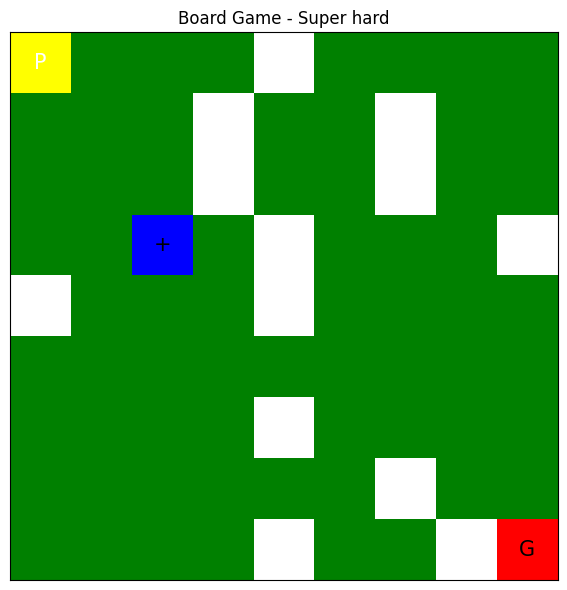

Game Type: Board | Difficulty: Super hard
Maximum Moves Allowed: 12
Goal: Move 'P' to 'G', collecting '+' and avoiding 'X'


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

class GameGenerator:
    def __init__(self):
        """Initialize the game generator with different game types and difficulties."""
        self.game_types = {
            'board': self.generate_board_game,
            'maze': self.generate_maze_game,
            'puzzle': self.generate_puzzle_game
        }

        self.difficulties = ['super easy', 'easy', 'medium', 'hard', 'super hard']

    def create_game(self, game_type, difficulty):
        """Create a game based on the selected type and difficulty."""
        if game_type not in self.game_types:
            print(f"Game type '{game_type}' not found. Available types: {', '.join(self.game_types.keys())}")
            return None

        if difficulty not in self.difficulties:
            print(f"Difficulty '{difficulty}' not found. Available difficulties: {', '.join(self.difficulties)}")
            return None

        # Generate the game using the appropriate function
        return self.game_types[game_type](difficulty)

    def difficulty_to_params(self, difficulty):
        """Convert difficulty level to numerical parameters."""
        difficulty_index = self.difficulties.index(difficulty)

        # Base parameters
        size = 5 + difficulty_index  # 5 to 9
        obstacles = int(size * (0.5 + difficulty_index * 0.25))  # Increasing obstacle density
        bonuses = max(1, int(size * (0.5 - difficulty_index * 0.1)))  # Decreasing bonuses
        moves = int(size * (3 - difficulty_index * 0.4))  # Decreasing move allowance

        return {
            'size': size,
            'obstacles': obstacles,
            'bonuses': bonuses,
            'moves': moves
        }

    def generate_board_game(self, difficulty):
        """Generate a board game with the specified difficulty."""
        params = self.difficulty_to_params(difficulty)

        board = np.zeros((params['size'], params['size']))
        player_pos = [0, 0]
        goal_pos = [params['size']-1, params['size']-1]

        # Place obstacles
        obstacles_placed = 0
        while obstacles_placed < params['obstacles']:
            x, y = random.randint(0, params['size']-1), random.randint(0, params['size']-1)
            if (x, y) != tuple(player_pos) and (x, y) != tuple(goal_pos) and board[x, y] == 0:
                board[x, y] = -1
                obstacles_placed += 1

        # Place bonuses
        bonuses_placed = 0
        while bonuses_placed < params['bonuses']:
            x, y = random.randint(0, params['size']-1), random.randint(0, params['size']-1)
            if (x, y) != tuple(player_pos) and (x, y) != tuple(goal_pos) and board[x, y] == 0:
                board[x, y] = 1
                bonuses_placed += 1

        # Make sure there's a valid path
        if not self.check_path_exists(board, player_pos, goal_pos):
            return self.generate_board_game(difficulty)  # Try again if no path

        # Mark player and goal
        board_display = np.copy(board)
        x, y = player_pos
        board_display[x, y] = 2
        gx, gy = goal_pos
        board_display[gx, gy] = 3

        # Create a readable game state
        game_state = {
            'board': board,
            'board_display': board_display,
            'player_pos': player_pos,
            'goal_pos': goal_pos,
            'max_moves': params['moves'],
            'type': 'board',
            'difficulty': difficulty
        }

        return game_state

    def generate_maze_game(self, difficulty):
        """Generate a maze game with the specified difficulty."""
        params = self.difficulty_to_params(difficulty)
        size = params['size']

        # Create a maze using a simple algorithm (odd-sized maze for proper walls)
        maze_size = size * 2 + 1
        maze = np.ones((maze_size, maze_size))  # 1 = wall

        # Create a grid of cells
        for i in range(1, maze_size, 2):
            for j in range(1, maze_size, 2):
                maze[i, j] = 0  # 0 = path

        # Simple randomized DFS to create the maze
        visited = set()
        stack = [(1, 1)]
        visited.add((1, 1))

        while stack:
            x, y = stack[-1]

            # Get unvisited neighbors
            neighbors = []
            for dx, dy in [(0, 2), (2, 0), (0, -2), (-2, 0)]:
                nx, ny = x + dx, y + dy
                if (0 < nx < maze_size-1 and 0 < ny < maze_size-1 and
                    (nx, ny) not in visited):
                    neighbors.append((nx, ny, (x + dx//2, y + dy//2)))

            if neighbors:
                # Choose a random neighbor
                nx, ny, wall = random.choice(neighbors)
                # Remove the wall
                maze[wall] = 0
                # Add to visited
                visited.add((nx, ny))
                # Push to stack
                stack.append((nx, ny))
            else:
                # Backtrack
                stack.pop()

        # Create start and end points
        maze[1, 0] = 0  # Entrance
        maze[maze_size-2, maze_size-1] = 0  # Exit

        # Create a copy for display with player and goal
        maze_display = np.copy(maze)
        maze_display[1, 1] = 2  # Player
        maze_display[maze_size-2, maze_size-2] = 3  # Goal

        # Add some bonuses (difficulty affects number)
        bonuses = max(1, params['bonuses'] // 2)
        for _ in range(bonuses):
            while True:
                x, y = random.randint(1, maze_size-2), random.randint(1, maze_size-2)
                if maze[x, y] == 0 and maze_display[x, y] != 2 and maze_display[x, y] != 3:
                    maze_display[x, y] = 4  # Bonus
                    break

        game_state = {
            'board': maze,
            'board_display': maze_display,
            'player_pos': [1, 1],
            'goal_pos': [maze_size-2, maze_size-2],
            'max_moves': params['moves'] * 2,  # More moves for mazes
            'type': 'maze',
            'difficulty': difficulty
        }

        return game_state

    def generate_puzzle_game(self, difficulty):
        """Generate a sliding puzzle game with the specified difficulty."""
        params = self.difficulty_to_params(difficulty)
        size = min(5, params['size'])  # Limit to 5x5 for simplicity

        # Create a solved puzzle
        puzzle = np.arange(1, size*size + 1).reshape(size, size)
        puzzle[size-1, size-1] = 0  # Empty space

        # Shuffle based on difficulty
        moves = (size * size) * (1 + self.difficulties.index(difficulty))
        empty_pos = [size-1, size-1]

        # Make random valid moves
        for _ in range(moves):
            # Get possible moves (up, down, left, right)
            possible_moves = []
            x, y = empty_pos
            if x > 0:
                possible_moves.append((-1, 0))  # Up
            if x < size - 1:
                possible_moves.append((1, 0))  # Down
            if y > 0:
                possible_moves.append((0, -1))  # Left
            if y < size - 1:
                possible_moves.append((0, 1))  # Right

            # Choose a random move
            dx, dy = random.choice(possible_moves)
            nx, ny = x + dx, y + dy

            # Swap the empty space with the chosen tile
            puzzle[x, y], puzzle[nx, ny] = puzzle[nx, ny], puzzle[x, y]
            empty_pos = [nx, ny]

        # Create a display version
        puzzle_display = np.copy(puzzle)

        game_state = {
            'board': puzzle,
            'board_display': puzzle_display,
            'empty_pos': empty_pos,
            'max_moves': params['moves'] * 3,  # More moves for puzzles
            'type': 'puzzle',
            'difficulty': difficulty
        }

        return game_state

    def check_path_exists(self, board, start, goal):
        """Check if a path exists from start to goal using BFS."""
        size = board.shape[0]
        queue = [tuple(start)]
        visited = set(queue)

        while queue:
            x, y = queue.pop(0)

            if [x, y] == goal:
                return True

            # Check all four directions
            for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                nx, ny = x + dx, y + dy

                if (0 <= nx < size and 0 <= ny < size and
                    board[nx, ny] != -1 and (nx, ny) not in visited):
                    queue.append((nx, ny))
                    visited.add((nx, ny))

        return False

    def display_game(self, game_state):
        """Display the game state."""
        board = game_state['board_display']
        game_type = game_state['type']
        difficulty = game_state['difficulty']

        plt.figure(figsize=(6, 6))

        if game_type == 'board':
            # Board game colormap
            cmap = plt.cm.colors.ListedColormap(['white', 'green', 'blue', 'yellow', 'red'])
            bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5]
            norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

            plt.imshow(board, cmap=cmap, norm=norm)
            plt.title(f"Board Game - {difficulty.capitalize()}")

            # Add labels
            for i in range(board.shape[0]):
                for j in range(board.shape[1]):
                    if board[i, j] == -1:  # Obstacle
                        plt.text(j, i, 'X', ha='center', va='center', color='white', fontsize=15)
                    elif board[i, j] == 1:  # Bonus
                        plt.text(j, i, '+', ha='center', va='center', color='black', fontsize=15)
                    elif board[i, j] == 2:  # Player
                        plt.text(j, i, 'P', ha='center', va='center', color='white', fontsize=15)
                    elif board[i, j] == 3:  # Goal
                        plt.text(j, i, 'G', ha='center', va='center', color='black', fontsize=15)

        elif game_type == 'maze':
            # Maze colormap
            cmap = plt.cm.colors.ListedColormap(['white', 'black', 'blue', 'yellow', 'green'])
            bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
            norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)

            plt.imshow(board, cmap=cmap, norm=norm)
            plt.title(f"Maze Game - {difficulty.capitalize()}")

        elif game_type == 'puzzle':
            # Puzzle display
            cmap = plt.cm.Blues
            plt.imshow(board > 0, cmap=cmap)
            plt.title(f"Sliding Puzzle - {difficulty.capitalize()}")

            # Add numbers to the puzzle
            for i in range(board.shape[0]):
                for j in range(board.shape[1]):
                    if board[i, j] > 0:
                        plt.text(j, i, int(board[i, j]), ha='center', va='center',
                                color='white' if board[i, j] > board.shape[0] else 'black',
                                fontsize=15, fontweight='bold')

        plt.grid(True, color='k', linewidth=1)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

        # Print game info
        print(f"Game Type: {game_type.capitalize()} | Difficulty: {difficulty.capitalize()}")
        print(f"Maximum Moves Allowed: {game_state['max_moves']}")

        if game_type == 'board':
            print("Goal: Move 'P' to 'G', collecting '+' and avoiding 'X'")
        elif game_type == 'maze':
            print("Goal: Navigate from blue to yellow, collecting green bonuses")
        elif game_type == 'puzzle':
            print("Goal: Arrange numbers in order with empty space at bottom right")

def choose_and_generate_game():
    """Interactive function to choose and generate a game."""
    # Create a generator
    generator = GameGenerator()

    # Display available options
    print("Welcome to the AI Game Level Generator!")
    print("======================================")
    print("\nAvailable Game Types:")
    for i, game_type in enumerate(generator.game_types.keys(), 1):
        print(f"{i}. {game_type.capitalize()}")

    # Get user input for game type
    while True:
        try:
            type_choice = int(input("\nSelect game type (number): ")) - 1
            game_type = list(generator.game_types.keys())[type_choice]
            break
        except (IndexError, ValueError):
            print("Invalid choice. Please enter a valid number.")

    # Display difficulty options
    print("\nDifficulty Levels:")
    for i, diff in enumerate(generator.difficulties, 1):
        print(f"{i}. {diff.capitalize()}")

    # Get user input for difficulty
    while True:
        try:
            diff_choice = int(input("\nSelect difficulty (number): ")) - 1
            difficulty = generator.difficulties[diff_choice]
            break
        except (IndexError, ValueError):
            print("Invalid choice. Please enter a valid number.")

    # Generate the game
    print(f"\nGenerating {difficulty} {game_type} game...")
    game_state = generator.create_game(game_type, difficulty)

    # Display the game
    if game_state:
        generator.display_game(game_state)
        return game_state
    else:
        print("Game generation failed. Please try again.")
        return None

# Run the generator when executed
if __name__ == "__main__":
    choose_and_generate_game()